In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill
import pandas as pd
import plotly.express as ply_exp
import plotly.graph_objects as ply_go

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

float_pres = 'float64' # Definindo a precisão padrão para as análises

In [2]:
nomes = [
    "WENO-JS"     , "WENO-Z"      , "WENO-Z+"     , 
    "WENO-JS (M)" , "WENO-Z (M)"  , "WENO-Z+ (M)" , 
    "WENO-JS (MS)", "WENO-Z (MS)" , "WENO-Z+ (MS)", 
    "WENO-JS (BI)", "WENO-Z (BI)" , "WENO-Z+ (BI)",
    "WENO-ZC (M)" , "WENO-ZC (MS)", "WENO-ZC (BI)",
    "WENO-D", "WENO-D (M)" , "WENO-D (MS)", "WENO-D (BI)", 
    "WENO-A", "WENO-A (M)" , "WENO-A (MS)", "WENO-A (BI)"
]

API      = API_Numpy
equation = transp_equation
ε        = 10e-40
# ε        = 10e-12
# ε        = 10e-6
γ        = 1.4

WENOs = {}
WENOs[nomes[ 1]] = simulation(API, equation, WENO_Z_scheme, γ, mapping =     null_mapping, map_function = None, ε=ε).Sim

Weights = {}
Weights[nomes[ 0]] = simulation(API, equation, WENO_JS_scheme, γ, mapping =     null_mapping, map_function = None           , ε=ε).Get_weights
Weights[nomes[ 1]] = simulation(API, equation, WENO_Z_scheme , γ, mapping =     null_mapping, map_function = None           , ε=ε).Get_weights
Weights[nomes[ 2]] = simulation(API, equation, WENO_Zp_scheme, γ, mapping =     null_mapping, map_function = None           , ε=ε).Get_weights
Weights[nomes[ 3]] = simulation(API, equation, WENO_JS_scheme, γ, mapping =     post_mapping, map_function = Henrick_mapping, ε=ε).Get_weights
Weights[nomes[ 4]] = simulation(API, equation, WENO_Z_scheme , γ, mapping =     post_mapping, map_function = Henrick_mapping, ε=ε).Get_weights
Weights[nomes[ 5]] = simulation(API, equation, WENO_Zp_scheme, γ, mapping =     post_mapping, map_function = Henrick_mapping, ε=ε).Get_weights
Weights[nomes[ 6]] = simulation(API, equation, WENO_JS_scheme, γ, mapping =      pre_mapping, map_function = Hong_mapping   , ε=ε).Get_weights
Weights[nomes[ 7]] = simulation(API, equation, WENO_Z_scheme , γ, mapping =      pre_mapping, map_function = Hong_mapping   , ε=ε).Get_weights
Weights[nomes[ 8]] = simulation(API, equation, WENO_Zp_scheme, γ, mapping =      pre_mapping, map_function = Hong_mapping   , ε=ε).Get_weights
Weights[nomes[ 9]] = simulation(API, equation, WENO_JS_scheme, γ, mapping =      pre_mapping, map_function = BI_mapping     , ε=ε).Get_weights
Weights[nomes[10]] = simulation(API, equation, WENO_Z_scheme , γ, mapping =      pre_mapping, map_function = BI_mapping     , ε=ε).Get_weights
Weights[nomes[11]] = simulation(API, equation, WENO_Zp_scheme, γ, mapping =      pre_mapping, map_function = BI_mapping     , ε=ε).Get_weights
Weights[nomes[12]] = simulation(API, equation, WENO_ZC_scheme, γ, mapping = post_inv_mapping, map_function = Henrick_mapping, ε=ε).Get_weights
Weights[nomes[13]] = simulation(API, equation, WENO_ZC_scheme, γ, mapping =  pre_inv_mapping, map_function = Hong_mapping   , ε=ε).Get_weights
Weights[nomes[14]] = simulation(API, equation, WENO_ZC_scheme, γ, mapping =  pre_inv_mapping, map_function = BI_mapping     , ε=ε).Get_weights
Weights[nomes[15]] = simulation(API, equation, WENO_D_scheme , γ, mapping =     null_mapping, map_function = None           , ε=ε).Get_weights
Weights[nomes[16]] = simulation(API, equation, WENO_D_scheme , γ, mapping =     post_mapping, map_function = Henrick_mapping, ε=ε).Get_weights
Weights[nomes[17]] = simulation(API, equation, WENO_D_scheme , γ, mapping =      pre_mapping, map_function = Hong_mapping   , ε=ε).Get_weights
Weights[nomes[18]] = simulation(API, equation, WENO_D_scheme , γ, mapping =      pre_mapping, map_function = BI_mapping     , ε=ε).Get_weights
Weights[nomes[19]] = simulation(API, equation, WENO_A_scheme , γ, mapping =     null_mapping, map_function = None           , ε=ε).Get_weights
Weights[nomes[20]] = simulation(API, equation, WENO_A_scheme , γ, mapping =     post_mapping, map_function = Henrick_mapping, ε=ε).Get_weights
Weights[nomes[21]] = simulation(API, equation, WENO_A_scheme , γ, mapping =      pre_mapping, map_function = Hong_mapping   , ε=ε).Get_weights
Weights[nomes[22]] = simulation(API, equation, WENO_A_scheme , γ, mapping =      pre_mapping, map_function = BI_mapping     , ε=ε).Get_weights


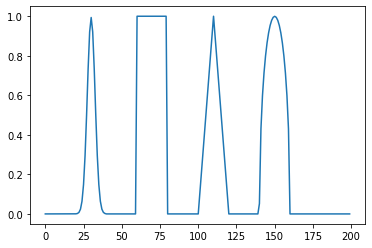

In [3]:
Δx = 0.01

# f_test = lambda x: np.where(x > 0.5, 0.0, 1.0)*np.where(x < -0.5, 0.0, 1.0)

def f_test(x):
    z = tf.constant(-0.7, dtype=float_pres)
    δ = tf.constant(0.005, dtype=float_pres)
    β = tf.math.log(tf.constant(2.0, dtype=float_pres))/(36.0*(δ**2.0))
    a = tf.constant(0.5, dtype=float_pres)
    α = tf.constant(10, dtype=float_pres)
    
    def G(x, β, z):
        return tf.math.exp(-β*(x-z)**2)
    
    def F(x, α, a):
        return tf.math.sqrt(tf.math.maximum(1-(α**2)*((x-a)**2),0))
    
    f1 = (G(x, β, z-δ) + 4*G(x, β, z) + G(x, β, z+δ))/6 # x in [-0.8, -0.6]
    f2 = 1                                              # x in [-0.4, -0.2]
    f3 = 1-tf.math.abs(10*(x-0.1))                      # x in [ 0.0,  0.2]
    f4 = (F(x, α, a-δ) + 4*F(x, α, a) + F(x, α, a+δ))/6 # x in [ 0.4,  0.6]
    f5 = 0                                              # otherwise
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.8),
        tf.math.less_equal(x, -0.6)
    )
    f1 = f1*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, -0.4),
        tf.math.less_equal(x, -0.2)
    )
    f2 = f2*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.0),
        tf.math.less_equal(x, 0.2)
    )
    f3 = f3*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(x, 0.4),
        tf.math.less_equal(x, 0.6)
    )
    f4 = f4*tf.cast(tf.where(condition, 1.0, 0.0), dtype=float_pres)
    
    f = f1 + f2 + f3 + f4 + f5
    
    return f

plt.plot(f_test(tf.range(-1, 1, Δx, dtype=float_pres)))

In [4]:
t_final  = 2
n        = 400
CFL      = 0.2
fator    = 10   # Quantas vezes menor é a malha para a solução de referência

fronteira = FronteiraPeriodica

Δx   = 2/n
x    = tf.range(-1, 1, Δx, dtype=float_pres)
init = lambda t: np.concatenate([x[t:], x[:t]], axis = 0)

u     = {}
pesos = {}

for nome in nomes:
    pesos[nome] = Weights[nome](f_test(x), Δx, fronteira)[0]
    print(nome+"              ")

n_ref  = n*fator
Δx_ref = 2/n_ref

WENO-JS              
WENO-Z              
WENO-Z+              
WENO-JS (M)              
WENO-Z (M)              
WENO-Z+ (M)              
WENO-JS (MS)              
WENO-Z (MS)              
WENO-Z+ (MS)              
WENO-JS (BI)              
WENO-Z (BI)              
WENO-Z+ (BI)              
WENO-ZC (M)              
WENO-ZC (MS)              
WENO-ZC (BI)              
WENO-D              
WENO-D (M)              
WENO-D (MS)              
WENO-D (BI)              
WENO-A              
WENO-A (M)              
WENO-A (MS)              
WENO-A (BI)              


In [9]:
df    = {}
y     = {}
label = {}
aux_x = tf.range(-1, 1, Δx, dtype=float_pres)

for nome in nomes:

    label_0 = tf.repeat([nome + ": omega 0"], [len(pesos[nome][:,0])])
    label_1 = tf.repeat([nome + ": omega 1"], [len(pesos[nome][:,1])])
    label_2 = tf.repeat([nome + ": omega 2"], [len(pesos[nome][:,2])])
    
    x           = tf.concat([           aux_x,            aux_x,            aux_x], axis = 0)
    y[nome]     = tf.concat([pesos[nome][:,0], pesos[nome][:,1], pesos[nome][:,2]], axis = 0)
    label[nome] = tf.concat([         label_0,          label_1,          label_2], axis = 0)
    
    df[nome] = pd.DataFrame(
        {
            "x"     : x     ,
            "y"     : y[nome]     ,
            "label" : label[nome]
        }
    )

In [10]:
for nome in nomes:

    fig = ply_exp.line(
        data_frame = df[nome]    ,
        x          = x           ,
        y          = y[nome]     ,
        color      = label[nome] ,
        log_y      = True
    )
    fig.add_trace(
        ply_go.Scatter(
            x    = tf.range(-1, 1, Δx_ref, dtype=float_pres)         ,
            y    = np.exp(f_test(tf.range(-1, 1, Δx_ref, dtype=float_pres))) , # u_ref, 
            mode = "lines"                                           ,
            line = ply_go.scatter.Line(color="#666666")              ,
            name = "Função",
        )
    )
    fig.update_yaxes(exponentformat="power")
#     fig.show()
    fig.write_html("htmls/formas pesos " + nome + " (T=0, epsilon=10e-40).html")
    

In [11]:
df    = {}
y     = {}
label = {}
aux_x = tf.range(-1, 1, Δx, dtype=float_pres)

for i in np.arange(3):
    
    x             = tf.range(-1, 1, Δx, dtype=float_pres)
    y[str(i)]     = pesos[nomes[0]][:,i]
    label[str(i)] = tf.repeat(["omega " + str(i) + ": " + nomes[0]], [len(pesos[nomes[0]])])
    
    tf.repeat([nome + ": omega 0"], [len(pesos[nome][:,0])])
    
    for j in range(1, len(nomes)):
        x             = tf.concat([            x, tf.range(-1, 1, Δx, dtype=float_pres)], axis = 0)
        y[str(i)]     = tf.concat([    y[str(i)], pesos[nomes[j]][:,i]], axis = 0)
        label[str(i)] = tf.concat([label[str(i)], tf.repeat(["omega " + str(i) + ": " + nomes[j]], [len(pesos[nomes[j]])])], axis = 0)
    
    df[str(i)] = pd.DataFrame(
        {
            "x"     : x     ,
            "y"     : y[str(i)]  ,
            "label" : label[str(i)]
        }
    )

In [12]:
for i in np.arange(3):

    fig = ply_exp.line(
        data_frame = df[str(i)]    ,
        x          = x             ,
        y          = y[str(i)]     ,
        color      = label[str(i)] ,
        log_y      = True
    )
    fig.add_trace(
        ply_go.Scatter(
            x    = tf.range(-1, 1, Δx_ref, dtype=float_pres)         ,
            y    = np.exp(f_test(tf.range(-1, 1, Δx_ref, dtype=float_pres))) , # u_ref, 
            mode = "lines"                                           ,
            line = ply_go.scatter.Line(color="#666666")              ,
            name = "Função",
        )
    )
    fig.update_yaxes(exponentformat="power")
#     fig.show()
    fig.write_html("htmls/formas peso omega " + str(i) + " (T=0, epsilon=10e-40).html")

In [5]:
t_final  = 2
n        = 400
CFL      = 0.2
fator    = 10   # Quantas vezes menor é a malha para a solução de referência

fronteira = FronteiraPeriodica

Δx   = 2/n
x    = tf.range(-1, 1, Δx, dtype=float_pres)
init = lambda t: np.concatenate([x[t:], x[:t]], axis = 0)
u     = WENOs["WENO-Z"](f_test(x), t_final, Δx, CFL, fronteira)

pesos = {}
for nome in nomes:
    pesos[nome] = Weights[nome](u, Δx, fronteira)[0]
    print(nome+"              ")

n_ref  = n*fator
Δx_ref = 2/n_ref

WENO-JS              
WENO-Z              
WENO-Z+              
WENO-JS (M)              
WENO-Z (M)              
WENO-Z+ (M)              
WENO-JS (MS)              
WENO-Z (MS)              
WENO-Z+ (MS)              
WENO-JS (BI)              
WENO-Z (BI)              
WENO-Z+ (BI)              
WENO-ZC (M)              
WENO-ZC (MS)              
WENO-ZC (BI)              
WENO-D              
WENO-D (M)              
WENO-D (MS)              
WENO-D (BI)              
WENO-A              
WENO-A (M)              
WENO-A (MS)              
WENO-A (BI)              


In [6]:
df    = {}
y     = {}
label = {}
aux_x = tf.range(-1, 1, Δx, dtype=float_pres)

for nome in nomes:

    label_0 = tf.repeat([nome + ": omega 0"], [len(pesos[nome][:,0])])
    label_1 = tf.repeat([nome + ": omega 1"], [len(pesos[nome][:,1])])
    label_2 = tf.repeat([nome + ": omega 2"], [len(pesos[nome][:,2])])
    
    x           = tf.concat([           aux_x,            aux_x,            aux_x], axis = 0)
    y[nome]     = tf.concat([pesos[nome][:,0], pesos[nome][:,1], pesos[nome][:,2]], axis = 0)
    label[nome] = tf.concat([         label_0,          label_1,          label_2], axis = 0)
    
    df[nome] = pd.DataFrame(
        {
            "x"     : x     ,
            "y"     : y[nome]     ,
            "label" : label[nome]
        }
    )

In [7]:
for nome in nomes:

    fig = ply_exp.line(
        data_frame = df[nome] ,
        x          = x               ,
        y          = y[nome]               ,
        color      = label[nome] ,
        log_y      = True
    )
    fig.add_trace(
        ply_go.Scatter(
            x    = tf.range(-1, 1, Δx, dtype=float_pres)         ,
            y    = np.exp(u) , # u_ref, 
            mode = "lines"                                           ,
            line = ply_go.scatter.Line(color="#666666")              ,
            name = "Função",
        )
    )
    fig.update_yaxes(exponentformat="power")
#     fig.show()
    fig.write_html("htmls/formas pesos " + nome + " (T=2, epsilon=10e-40).html")
    

In [7]:
df    = {}
y     = {}
label = {}
aux_x = tf.range(-1, 1, Δx, dtype=float_pres)

for i in np.arange(3):
    
    x             = tf.range(-1, 1, Δx, dtype=float_pres)
    y[str(i)]     = pesos[nomes[0]][:,i]
    label[str(i)] = tf.repeat(["omega " + str(i) + ": " + nomes[0]], [len(pesos[nomes[0]])])
    
    tf.repeat([nome + ": omega 0"], [len(pesos[nome][:,0])])
    
    for j in range(1, len(nomes)):
        x             = tf.concat([            x, tf.range(-1, 1, Δx, dtype=float_pres)], axis = 0)
        y[str(i)]     = tf.concat([    y[str(i)], pesos[nomes[j]][:,i]], axis = 0)
        label[str(i)] = tf.concat([label[str(i)], tf.repeat(["omega " + str(i) + ": " + nomes[j]], [len(pesos[nomes[j]])])], axis = 0)
    
    df[str(i)] = pd.DataFrame(
        {
            "x"     : x     ,
            "y"     : y[str(i)],
            "label" : label[str(i)]
        }
    )

In [8]:
for i in np.arange(3):

    fig = ply_exp.line(
        data_frame = df[str(i)]    ,
        x          = x             ,
        y          = y[str(i)]     ,
        color      = label[str(i)] ,
        log_y      = True
    )
    fig.add_trace(
        ply_go.Scatter(
            x    = tf.range(-1, 1, Δx, dtype=float_pres)         ,
            y    = np.exp(u) , # u_ref, 
            mode = "lines"                                           ,
            line = ply_go.scatter.Line(color="#666666")              ,
            name = "Função",
        )
    )
    fig.update_yaxes(exponentformat="power")
#     fig.show()
    fig.write_html("htmls/formas peso omega " + str(i) + " (T=2, epsilon=10e-40).html")